# Détection d'Émotions avec RNN & Embedding

### Objectif

L'objectif est de construire un classifieur capable de comprendre la nuance des émotions dans des tweets (dataset **Emotion** de Hugging Face). Contrairement au ML classique, nous allons utiliser une mémoire séquentielle pour capter le contexte.

Nous utiliserons le dataset **"Emotion"** disponible sur Hugging Face. Il contient des tweets classés en 6 catégories : *sadness, joy, love, anger, fear, surprise*.
**Lien du dataset :** [Hugging Face - Emotion Dataset](https://huggingface.co/datasets/dair-ai/emotion)


In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Embedding

In [2]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    # --- Фон ---
    "figure.facecolor": "#121212",
    "axes.facecolor": "#121212",
    "savefig.facecolor": "#121212",

    # --- Текст и оси ---
    "text.color": "white",
    "axes.labelcolor": "white",
    "axes.edgecolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",

    # --- Сетка ---
    "axes.grid": True,
    "grid.color": "#535252",
    "grid.alpha": 0.5,

    # --- Легенда ---
    "legend.facecolor": "#121212",
    "legend.edgecolor": "white",

    # --- Цвета линий (cycle) ---
    "axes.prop_cycle": plt.cycler(color=[
        "#6218B6",  # blue
        "#2532EE",  # orange
        "#1CE6C4",  # green
        "#0CD63F",  # red
        "#F1EE2A",  # purple
        "#F37C15",  # brown
        "#EE1924",  # cyan
    ]),

    # --- Толщина ---
    "lines.linewidth": 1.0,
})

In [3]:
from datasets import load_dataset
import pandas as pd

# 1. Téléchargement du dataset
# Le nom sur le hub est "dair-ai/emotion"
dataset = load_dataset("dair-ai/emotion")

# 2. Aperçu de la structure
print(dataset)

c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [4]:
X_train_sequences_t = pd.DataFrame(dataset["train"])
X_val_sequences_t = pd.DataFrame(dataset["validation"])
X_test_sequences_t = pd.DataFrame(dataset["test"])

y_train = X_train_sequences_t["label"]
y_val = X_val_sequences_t["label"]
y_test = X_test_sequences_t["label"]

print(X_train_sequences_t.head())

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Paramatres
max_words = 10000
max_len = 80

# Tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_sequences_t["text"])


X_train_sequences = tokenizer.texts_to_sequences(X_train_sequences_t["text"])
X_val_sequences = tokenizer.texts_to_sequences(X_val_sequences_t["text"])
X_test_sequences = tokenizer.texts_to_sequences(X_test_sequences_t["text"])


In [6]:
print(X_train_sequences[:5])

[[2, 139, 3, 679], [2, 40, 101, 60, 8, 15, 494, 5, 15, 3496, 553, 32, 60, 61, 128, 148, 76, 1480, 4, 22, 1255], [17, 3060, 7, 1149, 5, 286, 2, 3, 495, 438], [2, 24, 165, 8, 665, 27, 6, 4158, 2, 59, 47, 9, 13, 22, 72, 30, 6, 3497], [2, 24, 8, 1065]]


## Étape 1 : Préparation & Padding (Réflexion)

Les réseaux de neurones ont besoin de données de taille identique (tenseurs fixes). Comme les tweets ont des longueurs variées, nous utilisons le **Padding**.

**À faire :** 
1. Analysez la longueur maximale des tweets dans le dataset.
2. Appliquez un padding de taille **80** (suffisant pour ce dataset).
3. **Réflexion :** Testez les deux options `padding='pre'` et `padding='post'`.


In [7]:

from tensorflow.keras.preprocessing.sequence import pad_sequences

# On uniformise à 80 mots
# Option 1 : padding='pre' (les zéros au début)
# Option 2 : padding='post' (les zéros à la fin)
maxlen = 80

X_train_padded_pre = pad_sequences(X_train_sequences, maxlen=maxlen, padding='pre')
X_train_padded_post = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')

X_val_padded_pre = pad_sequences(X_val_sequences, maxlen=maxlen, padding='pre')
X_val_padded_post = pad_sequences(X_val_sequences, maxlen=maxlen, padding='post')

X_test_padded_pre = pad_sequences(X_test_sequences, maxlen=maxlen, padding='pre')
X_test_padded_post = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

In [8]:
print(f"pre", X_train_padded_pre[:1]), print(f"post", X_train_padded_post[:1])

pre [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   2 139   3 679]]
post [[  2 139   3 679   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]


(None, None)

## Étape 2 : La couche Embedding & le Masking

La première couche de votre modèle est la couche **Embedding**. C'est ici que les mots (indexés) deviennent des vecteurs de sens dans un espace géométrique.

**Le Masking :** Puisque nous avons ajouté beaucoup de "vide" (les zéros du padding), nous ne voulons pas que le modèle s'épuise à calculer du néant.

En ajoutant `mask_zero=True`, vous dites au modèle : *"Ignore les index 0, ils ne servent qu'à boucher les trous, ne les utilise pas pour ta mémoire."*



In [9]:
from tensorflow.keras import layers, models


vocab_size = len(tokenizer.word_index) + 1

model = models.Sequential()

In [10]:
# vocab_size : nb de mots du dictionnaire, embedding_dim : taille du vecteur (ex: 128), input_length : taille du padding (80)
model.add(layers.Embedding(
    input_dim=vocab_size,
    output_dim=128,
    input_length=maxlen,
    mask_zero=True
    ))


c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Étape 3 : Construction du Modèle RNN

Créez un modèle `Sequential` comprenant :

1. Une couche `Embedding` (taille de sortie : 128).
2. Une couche `LSTM` (64 unités) pour la mémoire séquentielle.
3. Une couche `Dense` de sortie pour la classification.

**Attention aux réglages :**

* Nous avons **6 émotions** à prédire. Quelle fonction d'activation choisir ?
* Les labels sont des entiers (0, 1, 2...). Quelle fonction de `loss` est la plus adaptée ?



In [11]:
model.add(layers.LSTM(64))
model.add(layers.Dense(6, activation="softmax"))  # 6 émotions

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Étape 4 : Classification & Analyse

* Entraînez le modèle sur 5 à 10 époques.
* Comparez vos résultats avec ceux obtenus lundi en Machine Learning classique.
* **Test :** Essayez de prédire l'émotion de phrases complexes comme :
  * *"I am not that happy about the results"*
  * *"Surprisingly, it was not as bad as I thought"*

Respectez les bonne pratiques et affichez la matrice de confusion et le rapport de classification

In [12]:
n_epoch = 20

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,       # on divise le LR par 2
    patience=1,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train_padded_post,
    y_train,
    validation_data=(X_val_padded_post, y_val),
    epochs=n_epoch,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6212 - loss: 1.0412 - val_accuracy: 0.8615 - val_loss: 0.4542 - learning_rate: 0.0010
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9156 - loss: 0.2585 - val_accuracy: 0.9140 - val_loss: 0.2629 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9568 - loss: 0.1252 - val_accuracy: 0.9110 - val_loss: 0.2583 - learning_rate: 0.0010
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9747 - loss: 0.0772
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9736 - loss: 0.0787 - val_accuracy: 0.9120 - val_loss: 0.2752 - learning_rate: 0.0010
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9863 - loss: 0.0437
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9852 - loss:

In [14]:
# Évaluation sur le test set
test_loss, test_acc = model.evaluate(X_test_padded_post, y_test)
print("Test accuracy:", test_acc)

history.history["test_accurancy"] = [test_acc]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9200 - loss: 0.2208
Test accuracy: 0.9200000166893005


In [15]:
import numpy as np

y_pred_proba = model.predict(X_test_padded_post)
y_pred = np.argmax(y_pred_proba, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       581
           1       0.94      0.94      0.94       695
           2       0.80      0.87      0.83       159
           3       0.95      0.88      0.91       275
           4       0.90      0.89      0.89       224
           5       0.74      0.76      0.75        66

    accuracy                           0.92      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.92      0.92      0.92      2000



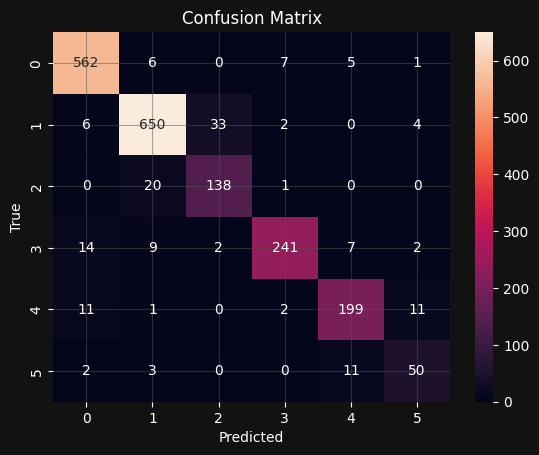

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [18]:
test_sentences = [
    "I am not that happy about the results",
    "Surprisingly, it was not as bad as I thought"
]

seq = tokenizer.texts_to_sequences(test_sentences)
padded = pad_sequences(seq, maxlen=80, padding="post")

pred = model.predict(padded)
pred_labels = np.argmax(pred, axis=1)

print(pred_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[1 0]


In [19]:
labels_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

for t, s, p in zip(test_sentences, X_test_sequences, pred_labels):
    print(t, "→", s, "→", labels_map[p])

I am not that happy about the results → [17, 8, 203, 715, 15, 17, 26, 46, 5595, 114, 58] → joy
Surprisingly, it was not as bad as I thought → [17, 1, 11, 243, 37, 2, 3, 469] → sadness


# Ameliorer le model

In [20]:
model_amel = models.Sequential()

# Embedding
model_amel.add(layers.Embedding(
    input_dim=vocab_size,
    output_dim=128,
    input_length=maxlen,
    mask_zero=True
))

# Bidirectional LSTM с возвращением последовательности
model_amel.add(layers.Bidirectional(
    layers.LSTM(64, return_sequences=True)
))

# Еще один LSTM уровень (stacked)
model_amel.add(layers.Bidirectional(
    layers.LSTM(32)
))

# Dropout для регуляризации
model_amel.add(layers.Dropout(0.5))

# Dense для классификации
model_amel.add(layers.Dense(6, activation="softmax"))

# Компиляция
model_amel.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,       # on divise le LR par 2
    patience=1,
    min_lr=1e-6,
    verbose=1
)

model_amel.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
history_amel = model_amel.fit(
    X_train_padded_pre,
    y_train,
    validation_data=(X_val_padded_pre, y_val),
    epochs=n_epoch,
    batch_size=32,
    callbacks=[early_stop,  reduce_lr]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.6302 - loss: 0.9771 - val_accuracy: 0.8790 - val_loss: 0.3776 - learning_rate: 0.0010
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9219 - loss: 0.2361 - val_accuracy: 0.9195 - val_loss: 0.2261 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9623 - loss: 0.1162
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.9571 - loss: 0.1267 - val_accuracy: 0.9185 - val_loss: 0.2556 - learning_rate: 0.0010
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9769 - loss: 0.0688
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9771 - loss: 0.0684 - val_accuracy: 0.9230 - val_loss: 0.2798 - learning_rate: 5.0000e-04
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9852 - lo

In [22]:
# Évaluation sur le test set
test_loss, test_acc = model_amel.evaluate(X_test_padded_pre, y_test)
print("Test accuracy:", test_acc)

history_amel.history["test_accurancy"] = [test_acc]

y_pred_proba = model_amel.predict(X_test_padded_pre)
y_pred = np.argmax(y_pred_proba, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9070 - loss: 0.2366
Test accuracy: 0.9070000052452087
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


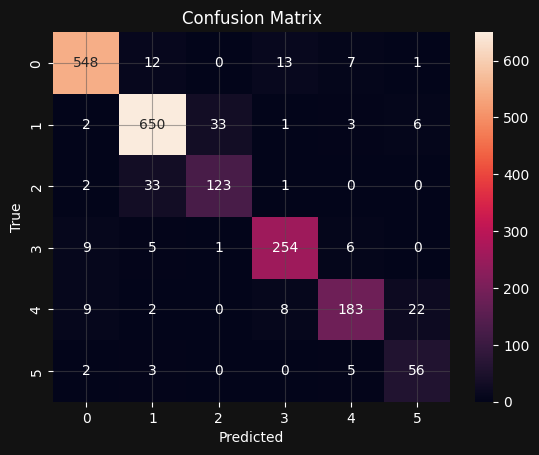

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [24]:
labels_map

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

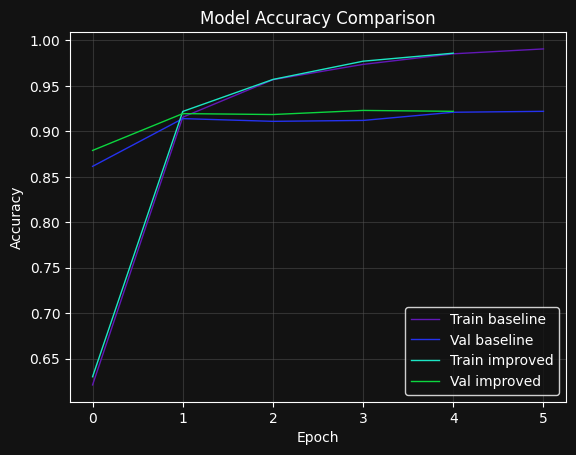

In [25]:
import matplotlib.pyplot as plt

plt.figure()

# Baseline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Améliorée
plt.plot(history_amel.history['accuracy'])
plt.plot(history_amel.history['val_accuracy'])

plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.legend([
    "Train baseline",
    "Val baseline",
    "Train improved",
    "Val improved"
])

plt.show()


## Étape 5 : Transfer Learning
Au lieu de laisser TensorFlow initialiser les vecteurs au hasard, on lui injecte une matrice de poids fixe. On règle ensuite le paramètre `trainable=False`. Cela signifie que pendant l'entraînement, le modèle va ajuster ses neurones de décision (Dense) et sa mémoire (LSTM), mais il ne touchera pas aux définitions des mots. C'est un gain de temps énorme et cela permet de travailler avec de petits jeux de données.

```python
# --- 1. CHARGEMENT DES DONNÉES ---
# On récupère les tweets du dataset "Emotion"
dataset = load_dataset("dair-ai/emotion")
df_train = pd.DataFrame(dataset['train'])
texts = df_train['text'].tolist()
```

On doit tokeniser puis on devra les padder

```python
# --- 2. TOKENIZATION (Le passage aux nombres) ---
# On crée le dictionnaire (ex: 'happy' -> 12)
max_words = 10000 
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

# On transforme les phrases en listes de chiffres
sequences = tokenizer.texts_to_sequences(texts)

# Padding : On égalise la longueur à 80 mots (Pre-padding conseillé)
X_train = pad_sequences(sequences, maxlen=80, padding='pre')
```

Création de la matrice d'embedding en la réduisant (la matrice complète est énorme)

```python
# --- 3. CHARGEMENT DU SAVOIR DE GOOGLE (Word2Vec) ---
# Téléchargement du modèle pré-entraîné
print("Chargement de Word2Vec Google News...")
google_model = api.load("word2vec-google-news-300")

# --- 4. CRÉATION DE LA MATRICE DE CORRESPONDANCE (Mapping) ---
# On crée une matrice vide (lignes = mots du tokenizer, colonnes = 300 dim de Google)
vocab_size = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in google_model:
        # On injecte le vecteur de Google à la ligne correspondante
        embedding_matrix[i] = google_model[word]
```

La couche d'embedding utilisera la `embedding_matrix` 

```python
# --- 5. CRÉATION DE LA COUCHE D'EMBEDDING TENSORFLOW ---
# Cette couche sera la première de notre modèle Sequential
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=300,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    input_length=80,
    trainable=False,  # On "gèle" pour ne pas perdre le savoir de Google
    mask_zero=True    # On ignore les zéros du padding
)

print("Pipeline terminé : La couche d'embedding est prête à être intégrée !")
```

---

### Aide-mémoire pour la couche de sortie :

| Nombre de classes | Activation | Loss Function |
| --- | --- | --- |
| 2 (Binaire) | `sigmoid` | `binary_crossentropy` |
| **6 (Multi-classe)** | **`softmax`** | **`sparse_categorical_crossentropy`** |

In [26]:
# --- 1. CHARGEMENT DES DONNÉES ---
# On récupère les tweets du dataset "Emotion"
dataset = load_dataset("dair-ai/emotion")
df_train = pd.DataFrame(dataset['train'])

texts = df_train['text'].tolist()

# --- 2. TOKENIZATION (Le passage aux nombres) ---
# On crée le dictionnaire (ex: 'happy' -> 12)
max_words = 10000 
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

# On transforme les phrases en listes de chiffres
sequences = tokenizer.texts_to_sequences(texts)

# Padding : On égalise la longueur à 80 mots (Pre-padding conseillé)
X_train = pad_sequences(sequences, maxlen=80, padding='pre')

In [27]:
import gensim.downloader as api


# --- 3. CHARGEMENT DU SAVOIR DE GOOGLE (Word2Vec) ---
# Téléchargement du modèle pré-entraîné
print("Chargement de Word2Vec Google News...")
google_model = api.load("word2vec-google-news-300")

Chargement de Word2Vec Google News...


In [28]:
# --- 4. CRÉATION DE LA MATRICE DE CORRESPONDANCE (Mapping) ---
# On crée une matrice vide (lignes = mots du tokenizer, colonnes = 300 dim de Google)
vocab_size = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in google_model:
        # On injecte le vecteur de Google à la ligne correspondante
        embedding_matrix[i] = google_model[word]


# --- 5. CRÉATION DE LA COUCHE D'EMBEDDING TENSORFLOW ---
# Cette couche sera la première de notre modèle Sequential
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=300,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    input_length=80,
    trainable=False,  # On "gèle" pour ne pas perdre le savoir de Google
    mask_zero=True    # On ignore les zéros du padding
)

print("Pipeline terminé : La couche d'embedding est prête à être intégrée !")

Pipeline terminé : La couche d'embedding est prête à être intégrée !


c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
model_pretrain = models.Sequential()

model_pretrain.add(embedding_layer)

# Bidirectional LSTM с возвращением последовательности
model_pretrain.add(layers.Bidirectional(
    layers.LSTM(64, return_sequences=True)
))

# Еще один LSTM уровень (stacked)
model_pretrain.add(layers.Bidirectional(
    layers.LSTM(32)
))

# Dropout для регуляризации
model_pretrain.add(layers.Dropout(0.5))

# Dense для классификации
model_pretrain.add(layers.Dense(6, activation="softmax"))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_pretrain.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,       # on divise le LR par 2
    patience=1,
    min_lr=1e-6,
    verbose=1
)

model_pretrain.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [30]:
history_pretrain = model_pretrain.fit(
    X_train_padded_post,
    y_train,
    validation_data=(X_val_padded_post, y_val),
    epochs=n_epoch,
    batch_size=32,
    callbacks=[early_stop,  reduce_lr]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.6101 - loss: 1.0674 - val_accuracy: 0.7900 - val_loss: 0.5636 - learning_rate: 0.0010
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.8365 - loss: 0.4744 - val_accuracy: 0.8870 - val_loss: 0.3109 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.8964 - loss: 0.2940 - val_accuracy: 0.9010 - val_loss: 0.2691 - learning_rate: 0.0010
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.9176 - loss: 0.2283 - val_accuracy: 0.9240 - val_loss: 0.2130 - learning_rate: 0.0010
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.9301 - loss: 0.1821 - val_accuracy: 0.9300 - val_loss: 0.1741 - learning_rate: 0.0010
Epoch 6/20
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9376 - loss: 0.1548
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.9341 - los

In [31]:
# Évaluation sur le test set
test_loss, test_acc = model_pretrain.evaluate(X_test_padded_post, y_test)
print("Test accuracy:", test_acc)
history_pretrain.history["test_accurancy"] = [test_acc]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9255 - loss: 0.1779
Test accuracy: 0.9254999756813049


In [32]:
y_pred = model_pretrain.predict(X_test_padded_post)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Unique y_test:", sorted(set(y_test)))
print("Unique y_pred:", sorted(set(y_pred_classes)))

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Unique y_test: [0, 1, 2, 3, 4, 5]
Unique y_pred: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]


In [33]:
for i in range(len(y_test)):
    true_label = y_test.iloc[i]
    pred_label = y_pred_classes[i]

    if true_label != pred_label:
        print(f"True: {labels_map[true_label]}, Pred: {labels_map[pred_label]}")
        print("Text:", X_train_sequences_t['text'][i])
        print("-" * 50)


True: fear, Pred: anger
Text: i feel like i have to make the suffering i m seeing mean something
--------------------------------------------------
True: sadness, Pred: joy
Text: i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter
--------------------------------------------------
True: fear, Pred: sadness
Text: i think it s the easiest time of year to feel dissatisfied
--------------------------------------------------
True: joy, Pred: love
Text: i only have a couple of things left to make and at the start of december i am done and feeling smug
--------------------------------------------------
True: anger, Pred: sadness
Text: i talk to dogs as i feel they cannot understand words but they can read emotions and know how to be supportive i decided i should go home
--------------------------------------------------
True: sadness, Pred: love
Text: i wont let me child cry it out because i feel that loving her and lily when she was li

In [34]:
max(history_pretrain.history['val_accuracy'])

0.9319999814033508

In [35]:
histories = [history, history_amel, history_pretrain]
histories_1 = []

for h in histories:
    train_losses = h.history['loss']
    train_accuracies = h.history['accuracy']   # <- правильно сохраняем accuracy
    test_losses = h.history['val_loss']
    test_accuracies = h.history['val_accuracy']
    
    # добавляем к списку кортеж (train_loss, train_acc, test_loss, test_acc)
    histories_1.append((train_losses, train_accuracies, test_losses, test_accuracies))


In [36]:
def compar_hist(histories, names=None, figsize=(12,5)):
    # --- Loss ---
    plt.figure(figsize=figsize)
    for i, h in enumerate(histories):
        train_losses, train_acc, test_losses, test_acc = h
        
        epochs = range(1, len(train_losses) + 1)  # <-- динамически под размер метрик
        
        label = f"{names[i]} Train" if names else f"Model {i+1} Train"
        plt.plot(epochs, train_losses, label=label, linestyle='--')
        label = f"{names[i]} Val" if names else f"Model {i+1} Val"
        plt.plot(epochs, test_losses, label=label, linestyle='-')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Val Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Accuracy ---
    plt.figure(figsize=figsize)
    for i, h in enumerate(histories):
        train_losses, train_acc, test_losses, test_acc = h
        
        epochs = range(1, len(train_acc) + 1)  # <-- динамически под размер метрик
        
        label = f"{names[i]} Train" if names else f"Model {i+1} Train"
        plt.plot(epochs, train_acc, label=label, linestyle='--')
        label = f"{names[i]} Val" if names else f"Model {i+1} Val"
        plt.plot(epochs, test_acc, label=label, linestyle='-')

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train vs Val Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


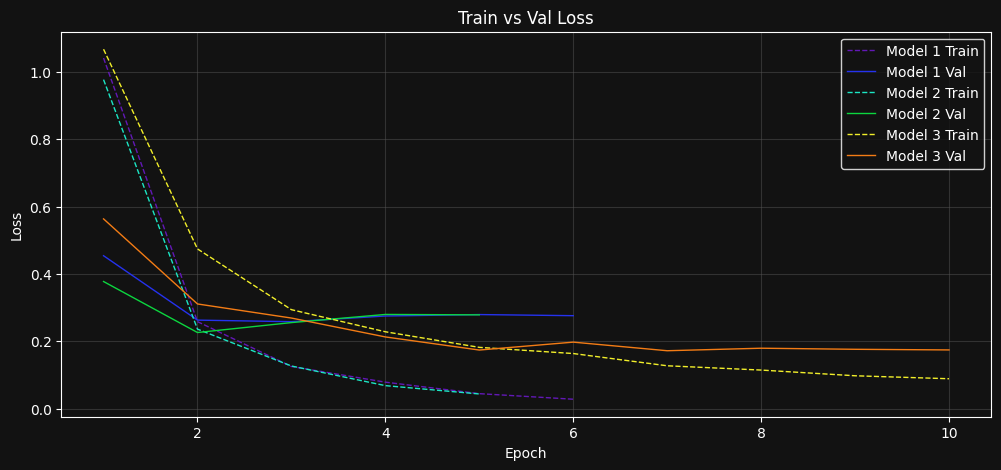

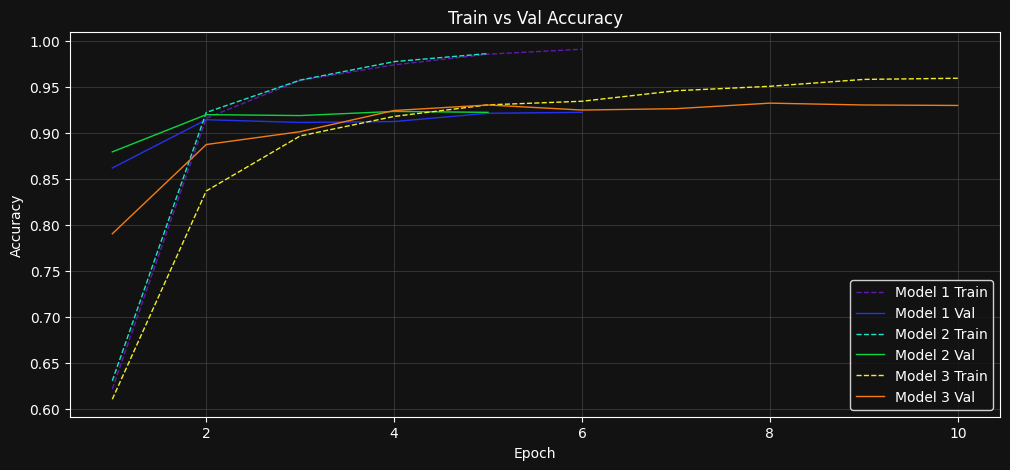

In [37]:
compar_hist(histories_1)

In [38]:
from tabulate import tabulate

histories = [history, history_amel, history_pretrain]
names = ["basic", "amel", "pretrained"]

table = []

for h, n in zip(histories, names):
    table.append([n, str(max(h.history['val_accuracy'])), str(max(h.history['test_accurancy']))])

print(tabulate(table, headers=["Model name", "Meilleur val accurancy", "Test accurancy"], tablefmt="fancy_grid"))

╒══════════════╤══════════════════════════╤══════════════════╕
│ Model name   │   Meilleur val accurancy │   Test accurancy │
╞══════════════╪══════════════════════════╪══════════════════╡
│ basic        │                    0.922 │           0.92   │
├──────────────┼──────────────────────────┼──────────────────┤
│ amel         │                    0.923 │           0.907  │
├──────────────┼──────────────────────────┼──────────────────┤
│ pretrained   │                    0.932 │           0.9255 │
╘══════════════╧══════════════════════════╧══════════════════╛


## class_weights

In [55]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# y_train — массив с метками (0–5)
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weight_dict = {int(k): round(float(v), 3) for k, v in zip(classes, class_weights)}
print(class_weight_dict)


{0: 0.572, 1: 0.497, 2: 2.045, 3: 1.235, 4: 1.377, 5: 4.662}


In [56]:
model_pretrain_st = models.Sequential()

model_pretrain_st.add(embedding_layer)

# Bidirectional LSTM с возвращением последовательности
model_pretrain_st.add(layers.Bidirectional(
    layers.LSTM(64, return_sequences=True)
))

# Еще один LSTM уровень (stacked)
model_pretrain_st.add(layers.Bidirectional(
    layers.LSTM(32)
))

# Dropout для регуляризации
model_pretrain_st.add(layers.Dropout(0.5))

# Dense для классификации
model_pretrain_st.add(layers.Dense(6, activation="softmax"))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_pretrain_st.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,       # on divise le LR par 2
    patience=1,
    min_lr=1e-6,
    verbose=1
)

model_pretrain_st.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [57]:
history_st = model_pretrain_st.fit(
    X_train_padded_post,
    y_train,
    validation_data=(X_val_padded_post, y_val),
    epochs=n_epoch,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5311 - loss: 1.1591 - val_accuracy: 0.7220 - val_loss: 0.7450 - learning_rate: 0.0010
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.7930 - loss: 0.5301 - val_accuracy: 0.8415 - val_loss: 0.4405 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.8672 - loss: 0.3427 - val_accuracy: 0.8800 - val_loss: 0.3363 - learning_rate: 0.0010
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.8990 - loss: 0.2599 - val_accuracy: 0.9160 - val_loss: 0.2368 - learning_rate: 0.0010
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9231 - loss: 0.1977
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.9182 - loss: 0.2077 - val_accuracy: 0.9085 - val_loss: 0.2461 - learning_rate: 0.0010
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.9318 - los

In [58]:
y_pred = model_pretrain_st.predict(X_test_padded_post)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=list(labels_map.values())))

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
              precision    recall  f1-score   support

     sadness       0.98      0.95      0.96       581
         joy       0.98      0.90      0.94       695
        love       0.74      0.97      0.84       159
       anger       0.91      0.94      0.92       275
        fear       0.92      0.87      0.89       224
    surprise       0.66      0.92      0.77        66

    accuracy                           0.92      2000
   macro avg       0.87      0.93      0.89      2000
weighted avg       0.93      0.92      0.93      2000



In [60]:
# Évaluation sur le test set
test_loss, test_acc = model_pretrain_st.evaluate(X_test_padded_post, y_test)
print("Test accuracy:", test_acc)
history_st.history["test_accurancy"] = [test_acc]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9245 - loss: 0.2016
Test accuracy: 0.9244999885559082
